In [2]:
import sys

import monai
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from collections import defaultdict

import nibabel as nib
from nilearn import plotting

import pandas as pd
import numpy as np

from tqdm import tqdm

from MINIT.minit import MINiT
from monai.networks.nets import ViT
from monai import transforms
from my_vit import MyViT, MyVitAutoEnc
from rollout import VITAttentionRollout, VITAttentionGradRollout

import os
import shutil

from utils import read_config, get_dataloder
import wandb

from sklearn.metrics import precision_score, recall_score, roc_auc_score

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
wandb.login()

wandb: Currently logged in as: kotstantinovskii. Use `wandb login --relogin` to force relogin


True

In [4]:
#!pip install monai
#!pip install nilearn==0.9.2
#!pip install nibabel==4.0.2
#!pip install einops
#!pip install matplotlib
#!pip install wandb

In [5]:
adni_merge_1 = pd.read_csv('our_subj_adnimerge.csv').sort_values(['PTID', 'EXAMDATE']).reset_index(drop=True)
adni_merge_2 = pd.read_csv('ADNIMERGE.csv').sort_values(['PTID', 'EXAMDATE']).reset_index(drop=True)
adni_merge_1 = adni_merge_1[['PTID', 'VISCODE', 'DX_bl']]
adni_merge_2 = adni_merge_2[['PTID', 'VISCODE', 'DX_bl']]

/tmp/ipykernel_4335/9726765.py:2: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  adni_merge_2 = pd.read_csv('ADNIMERGE.csv').sort_values(['PTID', 'EXAMDATE']).reset_index(drop=True)


In [6]:
# какое количество классов во всем ADNI
from collections import Counter
Counter(pd.read_csv('ADNIMERGE.csv')['DX_bl'].values)

/tmp/ipykernel_4335/2513726996.py:3: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  Counter(pd.read_csv('ADNIMERGE.csv')['DX_bl'].values)


Counter({'LMCI': 5037,
         'CN': 4512,
         'EMCI': 2740,
         'AD': 1667,
         'SMC': 1037,
         nan: 10})

In [7]:
pd.read_csv('ADNIMERGE.csv')

/tmp/ipykernel_4335/4009778700.py:1: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('ADNIMERGE.csv')


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0.0,2020-01-09 04:20:17.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0.0,2020-01-09 04:20:17.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6.0,2020-03-25 15:43:58.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12.0,2020-01-09 04:20:17.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24.0,2020-01-09 04:20:17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14998,6309,114_S_6309,m24,114,ADNI3,ADNI3,2020-10-27,SMC,65.2,Female,...,NaN,NaN,NaN,NaN,1.0199,2.379190,28.49180,30,24.0,2020-11-06 04:21:15.0
14999,6385,024_S_6385,m24,24,ADNI3,ADNI3,2020-11-05,CN,66.6,Female,...,NaN,NaN,NaN,NaN,NaN,2.414780,28.91800,30,24.0,2020-11-06 04:21:15.0
15000,6574,941_S_6574,m24,941,ADNI3,ADNI3,2020-10-27,CN,73.5,Female,...,NaN,NaN,NaN,NaN,NaN,2.108140,25.24590,24,24.0,2020-11-06 04:21:15.0
15001,6575,941_S_6575,m24,941,ADNI3,ADNI3,2020-10-27,CN,73.5,Male,...,NaN,NaN,NaN,NaN,NaN,2.108140,25.24590,24,24.0,2020-11-06 04:21:15.0


In [6]:
# какое количество классов в нашем сэмпле ADNI
Counter(pd.read_csv('our_subj_adnimerge.csv')['DX_bl'].values)

Counter({'LMCI': 1430, 'CN': 775, 'AD': 409})

In [7]:
Counter(pd.read_csv('our_subj_adnimerge.csv')['COLPROT'].values)

Counter({'ADNI1': 2613, 'ADNI2': 1})

# Make dataset

In [8]:
BASE_PATH = '/home/NFS/caps/subjects/'
#BASE_PATH = '/home/druzhininapo/nfs/caps/subjects/'

In [9]:
# 170 208 180
# 85, 104, 90
# 57 70 60
#80, 96, 80
def make_dataset(adni_merge, labels=('AD', 'CN'), resize=(100, 100, 100), max_count=None):
    
    if max_count is None:
        max_count = len(np.unique(adni_merge_1[['PTID']].values))+1
    
    resizer = monai.transforms.Resize(resize)
    label2num = {
        labels[0]: 1,
        labels[1]: 0,
    }
    dataset = defaultdict(list)
    for subj in tqdm(np.unique(adni_merge_1[['PTID']].values)[:max_count]):
        subj_path = subj.replace('_', '')
        for ses in os.listdir(os.path.join(BASE_PATH, f"sub-ADNI{subj_path}")):
            subj_samples = adni_merge[adni_merge['PTID'] == subj]
            if subj_samples[subj_samples['VISCODE'] == ses.split('-')[1].lower()].shape[0] == 0:
                continue
            label_text = subj_samples[subj_samples['VISCODE'] == ses.split('-')[1].lower()]['DX_bl'].values[0]

            if label_text not in label2num:
                continue

            path_to_tensor = os.path.join(BASE_PATH, f"sub-ADNI{subj_path}", ses, 'deeplearning_prepare_data/image_based/t1_linear/')
            path_to_img = ''
            for name_img in os.listdir(os.path.join(BASE_PATH, f"sub-ADNI{subj_path}", ses, 't1_linear')):
                if 'Crop_res-1x1x1_T1w' in name_img:
                    path_to_img = os.path.join(BASE_PATH, f"sub-ADNI{subj_path}", ses, 't1_linear', name_img)
            image_tensor = torch.load(os.path.join(path_to_tensor, os.listdir(path_to_tensor)[0]))

            if resize:
                image_tensor = resizer(image_tensor).get_array()

            dataset[subj].append((image_tensor,
                                  label2num[label_text],
                                  os.path.join(path_to_tensor, os.listdir(path_to_tensor)[0]),
                                  path_to_img,))

    return dataset

In [10]:
dataset_dict = make_dataset(adni_merge_1, resize=(96, 96, 96), max_count=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Normalization

In [ ]:
#normalize
#normalizer = 'MinMax'
normalizer = 'Std'
normalizer = None
all_nums = []
for key in tqdm(dataset_dict.keys()):
    for img, label in dataset_dict[key]:
        all_nums += list(img[img != 0.0])
        
mean_normalize = np.mean(all_nums)
std_normalize = np.std(all_nums)

for key in tqdm(dataset_dict.keys()):
    for i, (img, label) in enumerate(dataset_dict[key]):
        if normalizer == 'MinMax':
            img = img / mean_normalize
        elif normalizer == 'Std':
            img[img != 0.0] = (img[img != 0.0] - mean_normalize) / std_normalize 
        dataset_dict[key][i] = (img, label)

# Train classification

In [16]:
transfomation = transforms.Compose([
            transforms.RandFlip(prob=0.5, spatial_axis=0),
            transforms.RandFlip(prob=0.5, spatial_axis=1),
            transforms.RandFlip(prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
            transforms.RandScaleIntensity(factors=0.1, prob=0.5),
            transforms.RandShiftIntensity(offsets=0.1, prob=0.5),])

transfomation_normalize = transforms.Compose([ 
    transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
])

In [17]:
def train_vit(dataset_dict, name_config, transfomation=None):
    config_params = read_config(name_config)
    run = wandb.init(
            project="transfromers_brain_interpretation",
            reinit=True,
            config=config_params,)
    wandb_table = wandb.Table(columns=["Fold", "Mean AUC", "std"])
        
    auc_folds = []
    
    if not os.path.exists(config_params['result_path']):
        os.mkdir(config_params['result_path'])
    
    shutil.copy(os.path.join('./exp_configs/', name_config), config_params['result_path'])

    file_log = open(os.path.join(config_params['result_path'], 'logs.txt'), 'w')

    print(f"Name of exp: {config_params['name_exp']}")
    #file_log.write(f"Name of exp: {config_params['name_exp']}\n")

    device = torch.device(config_params['global_params']['device'] if torch.cuda.is_available() else "cpu")

    max_auc_folds = []
    num_fold = 0
    for train_dataloader, test_dataloader in get_dataloder(dataset_dict,
                                                           config_params,
                                                           transfomation,):
        num_fold += 1
        #file_log.write(f"Fold: {num_fold}\n")

        if config_params['model_params']['model_name'] == 'MiNiT':
            model = MINiT(
                block_size = config_params['model_params']['block_size'],
                image_size = config_params['model_params']['image_size'],
                patch_size = config_params['model_params']['patch_size'],
                num_classes = config_params['model_params']['num_classes'],
                channels = config_params['model_params']['channels'],
                dim = config_params['model_params']['dim'],
                depth = config_params['model_params']['depth'],
                heads = config_params['model_params']['heads'],
                mlp_dim = config_params['model_params']['mlp_dim'],
            ).train().to(device)
        elif config_params['model_params']['model_name'] == 'ViT':
            model = MyViT(
                in_channels = config_params['model_params']['in_channels'],
                img_size = config_params['model_params']['img_size'],
                patch_size = config_params['model_params']['patch_size'],
                num_layers = config_params['model_params']['num_layers'],
                num_heads = config_params['model_params']['num_heads'],
                hidden_size = config_params['model_params']['hidden_size'],
                pos_embed = config_params['model_params']['pos_embed'],
                qkv_bias = config_params['model_params']['qkv_bias'],
                classification = config_params['model_params']['classification'],
                num_classes = config_params['model_params']['num_classes'],
                post_activation = config_params['model_params']['post_activation'],
                spatial_dims = config_params['model_params']['spatial_dims'],
                mode_classification = config_params['model_params']['mode_classification'],
            ).train().to(device)
        elif config_params['model_params']['model_name'] == 'AutoEncViT':
            model = MyVitAutoEnc(
                in_channels = config_params['model_params']['in_channels'],
                img_size = config_params['model_params']['img_size'],
                patch_size = config_params['model_params']['patch_size'],
                out_channels = config_params['model_params']['out_channels'],
                deconv_chns = config_params['model_params']['deconv_chns'],
                hidden_size = config_params['model_params']['hidden_size'],
                num_layers = config_params['model_params']['num_layers'],
                num_heads = config_params['model_params']['num_heads'],
                pos_embed = config_params['model_params']['pos_embed'],
                qkv_bias = config_params['model_params']['qkv_bias'],
                classification = config_params['model_params']['classification'],
                dropout_rate = config_params['model_params']['dropout_rate'],
                num_classes = config_params['model_params']['num_classes'],
                spatial_dims = config_params['model_params']['spatial_dims'],
                mode_classification = config_params['model_params']['mode_classification'],
            ).train().to(device)

        if config_params['training_params']['use_checkpoint']:
            model.load_state_dict(torch.load(config_params['training_params']['use_checkpoint']))

        wandb.watch(model, log='all')
        optimizer = optim.Adam(model.parameters(), lr=config_params['training_params']['lr'])
        loss = nn.BCELoss()

        auc_folds = []
        logits_pred = []
        y_test = []
        max_auc = -1.0
        for epoch in range(config_params['training_params']['epoch_num']):
            for step in ['train', 'test']:
                if step == 'train':
                    print(f"Train step")
                    #file_log.write(f"Train step\n")
                    model = model.train()
                    dataloader = train_dataloader
                else:
                    print(f"Test step")
                    #file_log.write(f"Test step\n")
                    model = model.eval()
                    dataloader = test_dataloader

                epoch_train_loss = 0.0
                for i, batch in enumerate(dataloader):
                    brain_img = batch['tensor'].to(device)
                    labels = batch['label'].to(device)

                    if step == 'train':
                        optimizer.zero_grad()

                    outputs, _ = model(brain_img)

                    if step == 'train':
                        loss_calc = loss(torch.squeeze(outputs, 1), labels.float())
                        loss_calc.backward()
                        optimizer.step()

                        epoch_train_loss += loss_calc.item()
                        wandb.log({f"Loss fold {num_fold}": epoch_train_loss / (i+1)})

                        if i % 10 == 0:
                            print(f"Epoch: {epoch+1}, step: {i+1} / {len(train_dataloader)}, loss: {epoch_train_loss / (i+1)}")
                            #file_log.write(f"Epoch: {epoch+1}, step: {i+1} / {len(train_dataloader)}, loss: {epoch_train_loss / (i+1)}\n")
                    else:
                        logits_pred.append(outputs.item())
                        y_test.append(labels.item())

                if step == 'test':
                    auc_fold = roc_auc_score(y_test, logits_pred)    

                    if auc_fold > max_auc:
                        max_auc = auc_fold
                        torch.save(model.state_dict(),
                                   os.path.join(config_params['result_path'],
                                   f"best_model_fold_{num_fold}.pth"))

                    auc_folds.append(auc_fold)
                    wandb.log({f"AUC fold {num_fold}": auc_fold})
                    print(f"AUC: {auc_fold}")
                    #file_log.write(f"AUC: {auc_fold}\n")

        max_auc_folds.append(max_auc)
        wandb_table.add_data(num_fold, max_auc, np.std(max_auc_folds)) 

    wandb_table.add_data('ALL', np.mean(max_auc_folds), np.std(max_auc_folds))
    run.log({"AUC folds": wandb_table})
    print(f"Mean AUC: {np.mean(max_auc_folds)}+/-{np.std(max_auc_folds)}")
    #file_log.write(f"Mean AUC: {np.mean(max_auc_folds)}+/-{np.std(max_auc_folds)}")
    #file_log.close()
    return auc_folds, max_auc_folds

In [18]:
name_config = 'ad_cn_vit_normalize_2.yaml'

In [19]:
read_config(name_config)

{'name_exp': 'AD vs CD ViT with augmentations, without pretrain, cls',
 'result_path': './results/ad_cd_vit_cls_2/',
 'global_params': {'device': 'cuda:0', 'random_state': 29},
 'model_params': {'model_name': 'ViT',
  'in_channels': 1,
  'img_size': [96, 96, 96],
  'patch_size': [16, 16, 16],
  'num_layers': 1,
  'num_heads': 16,
  'hidden_size': 128,
  'mlp_dim': 768,
  'pos_embed': 'conv',
  'qkv_bias': True,
  'classification': True,
  'num_classes': 1,
  'spatial_dims': 3,
  'dropout_rate': 0.0,
  'post_activation': 'Sigmoid',
  'mode_classification': 'cls'},
 'training_params': {'lr': 0.0001,
  'count_folds_splits': 10,
  'use_checkpoint': False,
  'verbose_make_dataset': True,
  'verbose_train': True,
  'thr_metirc': 0.5,
  'batch_size': 12,
  'epoch_num': 50,
  'transormation': True}}

In [ ]:
auc_folds, max_auc_folds = train_vit(dataset_dict, name_config, transfomation=transfomation)

In [ ]:
auc_folds, max_auc_folds = train_vit(dataset_dict, name_config, transfomation=transfomation)

In [189]:
print(f"Mean {np.mean(max_auc_folds)}, Std: {np.std(max_auc_folds)}")

Mean 0.8223537421691223, Std: 0.0387644669760611


In [24]:
print(f"Mean {np.mean(max_auc_folds)}, Std: {np.std(max_auc_folds)}")

Mean 0.6842171854992397, Std: 0.049219835112385604


# AutoEnc ViT

In [10]:
transfomation = transforms.Compose([
            transforms.RandFlip(prob=0.5, spatial_axis=0),
            transforms.RandFlip(prob=0.5, spatial_axis=1),
            transforms.RandFlip(prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
            transforms.RandScaleIntensity(factors=0.1, prob=0.5),
            transforms.RandShiftIntensity(offsets=0.1, prob=0.5),])

transfomation_normalize = transforms.Compose([ 
    transforms.NormalizeIntensity(nonzero=True, channel_wise=True),
])

In [11]:
#BASE_PATH = '/NFS/druzhinina/caps/subjects/'
BASE_PATH = '/home/druzhininapo/nfs/caps/subjects/'

In [27]:
def make_dataset(adni_merge, resize=(100, 100, 100), max_count=None):
    if max_count is None:
        max_count = len(np.unique(adni_merge_1[['PTID']].values))+1

    resizer = monai.transforms.Resize(resize)

    dataset = defaultdict(list)
    for subj in tqdm(np.unique(adni_merge_1[['PTID']].values)[:max_count]):
        subj_path = subj.replace('_', '')
        for ses in os.listdir(os.path.join(BASE_PATH, f"sub-ADNI{subj_path}")):
            subj_samples = adni_merge[adni_merge['PTID'] == subj]

            if subj_samples[subj_samples['VISCODE'] == ses.split('-')[1].lower()].shape[0] == 0:
                continue

            path_to_tensor = os.path.join(BASE_PATH, f"sub-ADNI{subj_path}", ses, 'deeplearning_prepare_data/image_based/t1_linear/')
            image_tensor = torch.load(os.path.join(path_to_tensor, os.listdir(path_to_tensor)[0]))

            if resize:
                image_tensor = resizer(image_tensor).get_array()

            dataset[subj].append((image_tensor, 'autoenc'))

    return dataset

In [ ]:
auto_dataset_dict = make_dataset(adni_merge_1, resize=(128, 128, 128), max_count=None)

In [14]:
def train_auto_enc_vit(dataset_dict, name_config, transfomation=None):
    config_params = read_config(name_config)
    auc_folds = []

    if not os.path.exists(config_params['result_path']):
        os.mkdir(config_params['result_path'])

    shutil.copy(os.path.join('./exp_configs/', name_config), config_params['result_path'])

    file_log = open(os.path.join(config_params['result_path'], 'logs.txt'), 'w')

    print(f"Name of exp: {config_params['name_exp']}")
    file_log.write(f"Name of exp: {config_params['name_exp']}\n")

    device = torch.device(config_params['global_params']['device'] if torch.cuda.is_available() else "cpu")

    max_mse_folds = []
    num_fold = 0
    for train_dataloader, test_dataloader in get_dataloder(dataset_dict,
                                                           config_params,
                                                           transfomation,
                                                           mode=config_params['training_params']['mode_loader']):

        if config_params['training_params']['mode_loader'] == 'kfold':
            num_fold += 1
            file_log.write(f"Fold: {num_fold}\n")
            print(f"Fold: {num_fold}\n")

        if config_params['model_params']['model_name'] == 'AutoEncViT':
            model = MyVitAutoEnc(
                in_channels = config_params['model_params']['in_channels'],
                img_size = config_params['model_params']['img_size'],
                patch_size = config_params['model_params']['patch_size'],
                out_channels = config_params['model_params']['out_channels'],
                deconv_chns = config_params['model_params']['deconv_chns'],
                hidden_size = config_params['model_params']['hidden_size'],
                num_layers = config_params['model_params']['num_layers'],
                num_heads = config_params['model_params']['num_heads'],
                pos_embed = config_params['model_params']['pos_embed'],
                qkv_bias = config_params['model_params']['qkv_bias'],
                classification = config_params['model_params']['classification'],
                dropout_rate = config_params['model_params']['dropout_rate'],
                num_classes = config_params['model_params']['num_classes'],
                spatial_dims = config_params['model_params']['spatial_dims'],
            ).train().to(device)

        if config_params['training_params']['use_checkpoint']:
            model.load_state_dict(torch.load(config_params['training_params']['use_checkpoint']))

        optimizer = optim.Adam(model.parameters(),
                               lr=config_params['training_params']['lr'])
        loss = nn.MSELoss()

        mse_folds = []
        max_mse = -1.0
        mse_test = []
        y_test = []
        for epoch in range(config_params['training_params']['epoch_num']):
            for step in ['train', 'test']:
                if step == 'test' and config_params['training_params']['mode_loader'] != 'kfold':
                    continue

                if step == 'train':
                    print(f"Train step")
                    file_log.write(f"Train step\n")
                    dataloader = train_dataloader
                    model = model.train()
                else:
                    print(f"Test step")
                    file_log.write(f"Test step\n")
                    dataloader = test_dataloader
                    model = model.eval()

                epoch_train_loss = 0.0
                for i, batch in enumerate(dataloader):
                    brain_img = batch['tensor'].to(device)

                    if step == 'train':
                        optimizer.zero_grad()

                    outputs, hidden_norm = model.forward_autoenc(brain_img)    

                    if step == 'train':
                        loss_calc = loss(torch.squeeze(brain_img, 1), torch.squeeze(outputs, 1)) + config_params['training_params']['lambda'] * torch.mean(hidden_norm**2)
                        loss_calc.backward()
                        optimizer.step()

                        epoch_train_loss += loss_calc.item()
                        if i % 10 == 0:
                            print(f"Epoch: {epoch+1}, step: {i+1} / {len(train_dataloader)}, loss: {epoch_train_loss / (i+1)}")
                            file_log.write(f"Epoch: {epoch+1}, step: {i+1} / {len(train_dataloader)}, loss: {epoch_train_loss / (i+1)}\n")
                    else:
                        mse_test.append(torch.mean((output_img - brain_img)**2).item())

                if step == 'test':
                    if np.mean(mse_test) > max_mse:
                        max_mse = np.mean(mse_test)
                        torch.save(model.state_dict(),
                                   os.path.join(config_params['result_path'],
                                   f"best_model_fold_{num_fold}.pth"))

                    mse_folds.append(np.mean(mse_test))

                    print(f"MSE: {np.mean(mse_test)}")
                    file_log.write(f"MSE: {np.mean(mse_test)}\n")

            if step == 'test':
                max_mse_folds.append(max_mse)

    if config_params['training_params']['mode_loader'] == 'kfold':
        print(f"Mean MSE: {np.mean(max_mse_folds)}+/-{np.std(max_mse_folds)}")
        file_log.write(f"Mean MSE: {np.mean(max_mse_folds)}+/-{np.std(max_mse_folds)}")
    else:
        torch.save(model.state_dict(),
                   os.path.join(config_params['result_path'],
                   f"model_all.pth"))
        
    file_log.close()
    
    return mse_folds, max_mse_folds

In [24]:
name_config = 'auto_enc_vit.yaml'

In [25]:
read_config(name_config)

{'name_exp': 'Auto Encoder ViT Augmentations',
 'result_path': './results/autoenc_vit_augmentations_test/',
 'global_params': {'device': 'cuda:1', 'random_state': 29},
 'model_params': {'model_name': 'AutoEncViT',
  'in_channels': 1,
  'img_size': [128, 128, 128],
  'patch_size': [16, 16, 16],
  'num_layers': 2,
  'out_channels': 1,
  'deconv_chns': 16,
  'num_heads': 16,
  'hidden_size': 128,
  'mlp_dim': 768,
  'pos_embed': 'conv',
  'qkv_bias': False,
  'classification': True,
  'num_classes': 1,
  'spatial_dims': 3,
  'dropout_rate': 0.05,
  'post_activation': 'Sigmoid'},
 'training_params': {'lr': 0.0001,
  'count_folds_splits': 10,
  'use_checkpoint': False,
  'verbose_make_dataset': True,
  'verbose_train': True,
  'thr_metirc': 0.5,
  'batch_size': 8,
  'epoch_num': 10,
  'transormation': True,
  'lambda': 0.1,
  'mode_loader': 'all'}}

In [26]:
mse_folds, max_mse_folds = train_auto_enc_vit(auto_dataset_dict, name_config, transfomation)

Name of exp: Auto Encoder ViT Augmentations
Train step
Epoch: 1, step: 1 / 3, loss: 0.41903921961784363
Train step
Epoch: 2, step: 1 / 3, loss: 0.4201211631298065
Train step
Epoch: 3, step: 1 / 3, loss: 0.4106864333152771
Train step
Epoch: 4, step: 1 / 3, loss: 0.4116491377353668
Train step
Epoch: 5, step: 1 / 3, loss: 0.4097016751766205
Train step
Epoch: 6, step: 1 / 3, loss: 0.4209468960762024
Train step
Epoch: 7, step: 1 / 3, loss: 0.4171842336654663
Train step
Epoch: 8, step: 1 / 3, loss: 0.3972965478897095
Train step
Epoch: 9, step: 1 / 3, loss: 0.3996458947658539
Train step
Epoch: 10, step: 1 / 3, loss: 0.4059605002403259


In [56]:
!nvidia-smi

Wed Apr 26 13:33:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:0B:00.0 Off |                    0 |
|  0%   90C    P0   102W / 150W |  18671MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10          Off  | 00000000:84:00.0 Off |                    0 |
|  0%   

In [ ]:
name_config = 'auto_enc_vit.yaml'

In [ ]:
mse_folds, max_mse_folds = train_vit(dataset_dict, name_config, transfomation=transfomation)

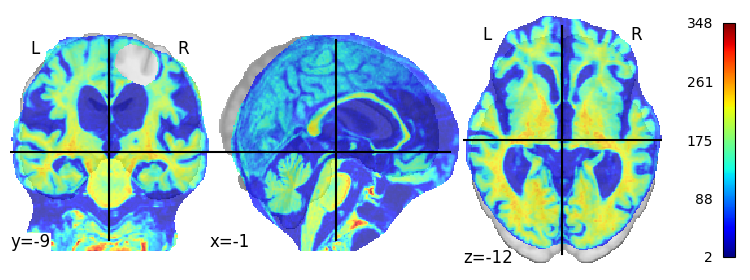

# Interpretation

In [11]:
img_dataset_dict = make_dataset(adni_merge_1, resize=False, max_count=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


In [12]:


class GradCAM(object):
    def __init__(self, model, input_size=None, verbose=False):
        self.model = model

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = self.model.norm
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if input_size:
            device = 'cpu'
            self.model(torch.zeros(1, 1, *(input_size), device=device))
            print('saliency_map size :', self.activations['value'].shape)


    def forward(self, input, class_idx):
        b, c, hh, w, l = input.size()

        logit, _ = self.model(input)
        #print(logit)
        score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward()
        gradients = self.gradients['value']
        activations = self.activations['value']
        print(gradients)
        
        # delete cls
        #gradients = gradients[:, 1:, :]
        #activations = activations[:, 1:, :]

        b, k, h = gradients.size()
        
        print(gradients)
        print(activations)

        #alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        #weights = alpha.view(b, k, 1, 1)

        saliency_map = (activations * gradients).mean(2)
        saliency_map = F.relu(saliency_map)
        #print(saliency_map.size())
        saliency_map = saliency_map.reshape(b, 4, 4, 4)
        #print(torch.unsqueeze(saliency_map, 0))
        #print(hh, w, l)
        saliency_map = F.upsample(torch.unsqueeze(saliency_map, 0), size=(hh, w, l), mode='trilinear', align_corners=False)
        
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


In [13]:
PATH_TO_RESULT = '/home/b.konstantinovskii/boris_NiT/results/ad_cd_vit_cls_2'

In [14]:
config_params = read_config(f'{PATH_TO_RESULT}/ad_cn_vit_normalize_2.yaml')



In [15]:
config_params

{'name_exp': 'AD vs CD ViT with augmentations, without pretrain, cls',
 'result_path': './results/ad_cd_vit_cls_2/',
 'global_params': {'device': 'cuda:0', 'random_state': 29},
 'model_params': {'model_name': 'ViT',
  'in_channels': 1,
  'img_size': [96, 96, 96],
  'patch_size': [16, 16, 16],
  'num_layers': 1,
  'num_heads': 16,
  'hidden_size': 128,
  'mlp_dim': 768,
  'pos_embed': 'conv',
  'qkv_bias': True,
  'classification': True,
  'num_classes': 1,
  'spatial_dims': 3,
  'dropout_rate': 0.0,
  'post_activation': 'Sigmoid',
  'mode_classification': 'cls'},
 'training_params': {'lr': 0.0001,
  'count_folds_splits': 10,
  'use_checkpoint': False,
  'verbose_make_dataset': True,
  'verbose_train': True,
  'thr_metirc': 0.5,
  'batch_size': 12,
  'epoch_num': 50,
  'transormation': True}}

In [16]:
model = MyViT(
                in_channels = config_params['model_params']['in_channels'],
                img_size = config_params['model_params']['img_size'],
                patch_size = config_params['model_params']['patch_size'],
                num_layers = config_params['model_params']['num_layers'],
                num_heads = config_params['model_params']['num_heads'],
                hidden_size = config_params['model_params']['hidden_size'],
                pos_embed = config_params['model_params']['pos_embed'],
                qkv_bias = config_params['model_params']['qkv_bias'],
                classification = config_params['model_params']['classification'],
                num_classes = config_params['model_params']['num_classes'],
                post_activation = config_params['model_params']['post_activation'],
                spatial_dims = config_params['model_params']['spatial_dims'],
                mode_classification = config_params['model_params']['mode_classification'],
            ).train().to('cpu')

model.load_state_dict(torch.load(f'{PATH_TO_RESULT}/best_model_fold_10.pth'))


<All keys matched successfully>

In [16]:
!ls /home/NFS/caps/subjects/sub-ADNI023S0388/



ses-M00  ses-M06  ses-M18  ses-M24  ses-M36  ses-M48


In [17]:
BASE_PATH = '/home/NFS/caps/subjects/'
subject_name = 'ADNI023S0388'
ses_name = 'M48'

In [18]:

path_to_img = f'{BASE_PATH}sub-{subject_name}/ses-{ses_name}/t1_linear/sub-{subject_name}_ses-{ses_name}_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w_brain_mask.nii.gz'
path_to_torch_img = f'{BASE_PATH}sub-{subject_name}/ses-{ses_name}/deeplearning_prepare_data/image_based/t1_linear/sub-{subject_name}_ses-{ses_name}_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'


In [19]:
_, label, path_to_tensor, path_to_img = img_dataset_dict['002_S_0619'][0]

In [20]:
rollout_vit = VITAttentionRollout(model)
rollout_grad_vit = VITAttentionGradRollout(model)
grad_cam = GradCAM(model, (64, 64, 64))

In [21]:
resizer = monai.transforms.Resize((96, 96, 96))
rollout_attn = rollout_vit(torch.unsqueeze(torch.tensor(resizer(torch.load(path_to_tensor)).get_array()), 0))
rollout_grad_attn = rollout_grad_vit(torch.unsqueeze(torch.tensor(resizer(torch.load(path_to_tensor)).get_array()), 0), 0)



/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [70]:
inter_img = F.interpolate(torch.unsqueeze(torch.unsqueeze(torch.tensor(rollout_attn), 0), 0),
           size=tuple(torch.load(path_to_torch_img).shape[1:]),
           mode='trilinear', align_corners=False)

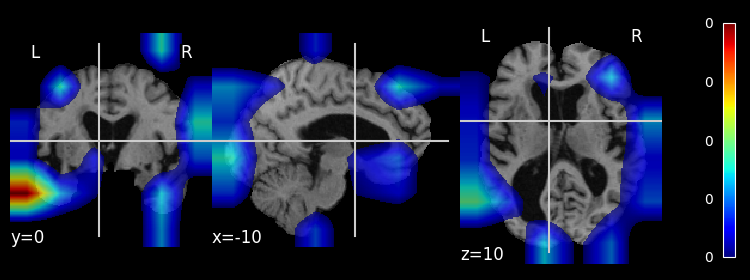

In [73]:
#path_img = '/home/druzhininapo/nfs/caps/subjects/sub-ADNI941S1311/ses-M24/t1_linear/sub-ADNI941S1311_ses-M24_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz'
image_nii = nib.load(path_to_img)
image_np = image_nii.get_fdata()

img_torch = torch.load(path_to_torch_img)

img = nib.Nifti1Image(img_torch[0].numpy(), affine=image_nii.affine)
inter_img_nifti = nib.Nifti1Image(inter_img[0][0].numpy(), affine=image_nii.affine)

plotting.plot_roi(inter_img_nifti,
                  img,
                  cut_coords=(-10, 0, 10),
                  colorbar=True,
                  cmap='jet',
                  threshold=0.15)



saliency_map size : torch.Size([1, 64, 128])


/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [34]:
import matplotlib.pyplot as plt

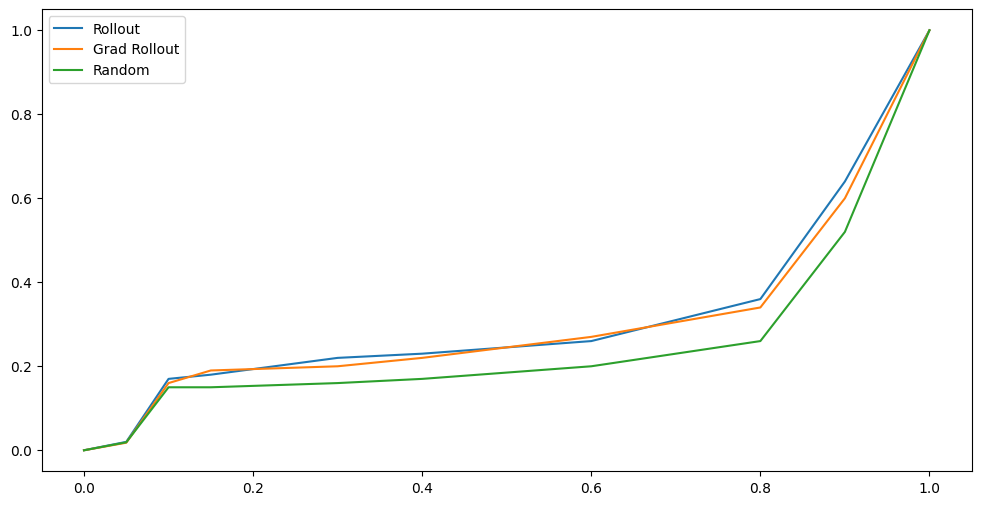